In [1]:
import yaml
import numpy as np

from scipy.stats import linregress

import matplotlib.pyplot as plt
%matplotlib inline

from electronfactors import (
    create_model, pull_data, fit_give, estimate_population_uncertainty,
    create_green_cm
)

In [2]:
run_full_calcualtion = False  # True

In [3]:
green_cm = create_green_cm()

def colour(x, alpha=1):
    result = list(green_cm(x))
    result[3] = alpha
    
    return result

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'20'})
# rc('text', usetex=True)

rc('legend', fontsize=16)

In [5]:
with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)
    
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

custom_label = label[~book_factor]

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

perimeter = np.pi / 2 * (3*(width + length) - np.sqrt((3*width + length)*(3*length + width)))
area = np.pi / 4 * width * length
eqPonA = perimeter / area

In [6]:
def test_amount(amount=8, n=1000):
    store = np.array([])
    
    for j in range(n):
        order = np.arange(len(width))
        np.random.shuffle(order)
        reference = order[0:amount]        
        check = np.setdiff1d(np.arange(len(width)), reference)        
        give = np.zeros(len(check))
        predictions = np.zeros(len(check))

        model = create_model(width[reference], eqPonA[reference], factor[reference])

        for i, value in enumerate(check):
            predictions[i] = model(width[value], eqPonA[value])
            give[i] = fit_give(
                width[value], eqPonA[value], 
                width[reference], eqPonA[reference], factor[reference])

        percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]

        valid = give < 0.5
        store = np.append(store, percent_prediction_differences[valid])
    
    std_store = np.std(store)
    
    return std_store

In [7]:
def test_amount_with_outlier(amount=8, n=1000, num_outliers=2):
    store = np.array([])
    
    for j in range(n):
        order = np.arange(len(width))
        np.random.shuffle(order)
        reference = order[0:amount]
        
        shift = np.floor(np.random.uniform(0,2, size=num_outliers)) * 0.04 - 0.02
        shifted_factor = factor[reference]
        shifted_factor[0:num_outliers] = shifted_factor[0:num_outliers] + shift
        
        check = np.setdiff1d(np.arange(len(width)), reference)
        
        give = np.zeros(len(check))
        predictions = np.zeros(len(check))

        model = create_model(width[reference], eqPonA[reference], shifted_factor)

        for i, value in enumerate(check):
            predictions[i] = model(width[value], eqPonA[value])
            give[i] = fit_give(
                width[value], eqPonA[value], 
                width[reference], eqPonA[reference], factor[reference])

        percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]

        valid = give < 0.5
        store = np.append(store, percent_prediction_differences[valid])            
    
    std_store = np.std(store)
    
    return std_store

In [8]:
amount_test = np.arange(8, 40)
std_store_no_outlier = np.zeros(len(amount_test))
std_store_one_outlier = np.zeros(len(amount_test))
std_store_two_outliers = np.zeros(len(amount_test))
std_store_four_outliers = np.zeros(len(amount_test))
std_store_six_outliers = np.zeros(len(amount_test))

In [9]:
if run_full_calcualtion:
    n = 30000
else:
    n = 20  # n = 30000

In [10]:
for i, amount in enumerate(amount_test):
    std_store_no_outlier[i] = test_amount(amount=amount, n=n)  # n=30000

In [11]:
for i, amount in enumerate(amount_test):
    std_store_one_outlier[i] = test_amount_with_outlier(amount=amount, n=n, num_outliers=1)

In [12]:
for i, amount in enumerate(amount_test):
    std_store_two_outliers[i] = test_amount_with_outlier(amount=amount, n=n, num_outliers=2)    

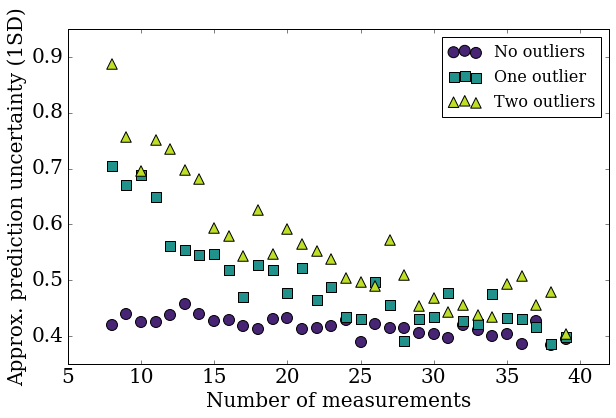

In [13]:
plt.figure(figsize=(6 * 1.618, 6))

plt.scatter(
    amount_test, std_store_no_outlier, s=120, lw=1, c=colour(0.1, alpha=1),
    label=r'No outliers'
)

plt.scatter(
    amount_test, std_store_one_outlier, marker='s', s=100, lw=1, c=colour(0.5, alpha=1),
    label=r'One outlier'
)

plt.scatter(
    amount_test, std_store_two_outliers, marker='^', s=110, lw=1, c=colour(0.9, alpha=1),
    label=r'Two outliers'
)




plt.xlabel(r'Number of measurements')
plt.ylabel(r'Approx. prediction uncertainty (1SD)')

plt.xlim([5,42])
plt.ylim([0.35,0.95])

plt.legend()

# plt.savefig('figures/change_with_number_measurements.png', bbox_inches='tight', dpi=600)
# plt.savefig('figures/change_with_number_measurements.eps', bbox_inches='tight')